In [1]:
from footix.models.bayesian import BayesianModel
from footix.data_io.footballdata import ScrapFootballData
from footix.metrics import rps, incertity, zscore
import numpy as np

# Loading the dataset:

Here, we are going to play with the season 2024-2025 of French division ligue 1, using the scrapper of [football-data](www.footbal-data.co.uk).

We are also going to divide the dataset in two parts. One for training the model and one for benchmarking its performances

In [2]:
dataset = ScrapFootballData(competition="FRA Ligue 1", season="2024-2025", path ="./data", force_reload=True).get_fixtures()

In [3]:
dataset.head()

,div,date,time,home_team,away_team,fthg,ftag,ftr,hthg,htag,...,b365_caha,pcahh,pcaha,max_cahh,max_caha,avg_cahh,avg_caha,bfecahh,bfecaha,match_id
0,F1,16/08/2024,19:45,Le Havre,Paris SG,1,4,A,0,1,...,2.00,1.95,1.97,1.95,2.02,1.89,1.95,1.95,2.02,Le Havre - Paris SG - 16/08/2024
1,F1,17/08/2024,16:00,Brest,Marseille,1,5,A,1,3,...,2.04,1.91,2.02,1.91,2.08,1.85,2.01,1.90,2.09,Brest - Marseille - 17/08/2024
2,F1,17/08/2024,18:00,Reims,Lille,0,2,A,0,1,...,1.70,2.14,1.81,2.14,1.85,2.07,1.80,2.13,1.86,Reims - Lille - 17/08/2024
3,F1,17/08/2024,20:00,Monaco,St Etienne,1,0,H,1,0,...,1.93,2.00,1.93,2.00,2.01,1.95,1.91,1.95,2.00,Monaco - St Etienne - 17/08/2024
4,F1,18/08/2024,14:00,Auxerre,Nice,2,1,H,1,1,...,2.11,1.82,2.13,1.83,2.17,1.77,2.10,1.84,2.16,Auxerre - Nice - 18/08/2024


In [4]:
train_dataset = dataset.iloc[:-9]
test_dataset = dataset.iloc[-9:]

# Initialization of the model and fitting


In [5]:
model = BayesianModel(n_teams=18, n_goals=20)

In [6]:
model.fit(X_train=train_dataset)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

# Let's compute some metrics

In [7]:
rps_list = []
incertity_list = []
zscore_list = []

def _helper_result(result_str: str)-> int:
    if result_str=="H":
        return 0
    if result_str=="D":
        return 1
    return 2

for idx, row in test_dataset.iterrows():
    probability = model.predict(home_team=row["home_team"], away_team=row["away_team"]).return_probas()
    outcome_idx = _helper_result(row["ftr"])
    rps_list.append(rps(probas=probability, outcome_idx=outcome_idx))
    zscore_list.append(zscore(probas=probability,rps_observed=rps_list[-1]))
    incertity_list.append(incertity(probas=probability, outcome_idx=outcome_idx))

In [8]:
print(f"Incertity metric : {np.mean(incertity_list)} +/- {np.std(incertity_list)}")
print(f"RPS metric : {np.mean(rps_list)} +/- {np.std(rps_list)}")
print(f"Z-score metric : {np.mean(zscore_list)} +/- {np.std(zscore_list)}")

Incertity metric : 0.7237055199453668 +/- 0.4110177078295434
RPS metric : 0.19595476471122797 +/- 0.15777836459229208
Z-score metric : 0.10075722799677359 +/- 0.6220588942296199


# Game focus

In [9]:
goal_matrix_object = model.predict(home_team="St Etienne", away_team="Toulouse")

In [10]:
probability = goal_matrix_object.return_probas()
print("St Etienne - Toulouse outcome probabilities")
print(f"Probability of home victory : {100*probability.proba_home:.2f} %")
print(f"Probability of a draw : {100*probability.proba_draw:.2f}")
print(f"Probability of away victory : {100*probability.proba_away:.2f}")

St Etienne - Toulouse outcome probabilities
Probability of home victory : 26.22 %
Probability of a draw : 23.55
Probability of away victory : 50.23


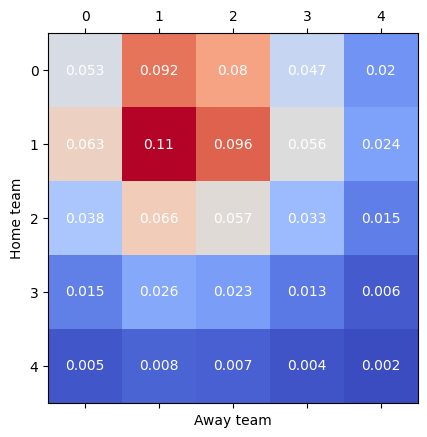

In [11]:
goal_matrix_object.visualize()

In [12]:
goal_matrix_object.get_probable_score()

(1, 1)

In [17]:
np.std(model.get_samples(home_team="St Etienne", away_team="Toulouse").proba_away)

0.11259106902781582